# 02 Tune CATE estimators

In this notebook, we will tune the hyperparemeters for our CATE methods.

In [1]:
from pathlib import Path

# Ensure standard output directories exist
for p in [
    Path("output"),
    Path("output/analysis"),
    Path("output/params"),
    Path("output/figures"),
    Path("output/tables"),
]:
    p.mkdir(parents=True, exist_ok=True)


### Contents:
1. Description of estimator library  
2. Setting up  
3. Actual tuning

## 1. Description of estimator library

We will consider the following estimators:

1. S-learner:  
A. RF  
B. XGB
2. T-learner:  
A. Lasso  
B. logistic  
C. RF  
D. XGB
3. X-learner:  
A. Outcome_learner: lasso, effect_learner: lasso  
B. Outcome_learner: logistic, effect_learner: lasso  
C. Outcome_learner: RF, effect_learner: lasso  
D. Outcome_learner: XGB, effect_learner: lasso
4. R-learner:  
A. Outcome_learner: lasso, effect_learner: lasso  
B. Outcome_learner: lasso, effect_learner: XGB  
C. Outcome_learner: RF, effect_learner: lasso  
E. Outcome_learner: RF, effect_learner: RF

R-learner base learner types were chosen independently at random from {lasso, RF, XGB}

We will tune the models for the 4 outcomes: GI, cardio, hypertension, severe GI, without perturbations.

## 2. Setting up

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import sys
import copy
import random
import joblib
import pickle

# Import sklearn methods
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [3]:
# Cap BLAS/OpenMP threads to avoid oversubscription with parallel CV
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"


In [4]:
# Load pre-saved analysis dataset from Analysis.ipynb
import pandas as pd
import numpy as np
from pathlib import Path

ANALYSIS_CSV = Path("data/analysis/analysis_df.csv")
if not ANALYSIS_CSV.exists():
    raise FileNotFoundError(f"Expected CSV not found at {ANALYSIS_CSV}. Run Analysis.ipynb to generate it.")

trainval_df = pd.read_csv(ANALYSIS_CSV)
print(f"Loaded analysis dataset: {trainval_df.shape[0]} rows, {trainval_df.shape[1]} columns")

# Filter to units with message == 1 and drop 'message' column
if "message" in trainval_df.columns:
    #trainval_df = trainval_df.loc[(trainval_df["message"] == 1) & (trainval_df["billpayfa"] == 0) & (trainval_df["debitfa"] == 0)].copy()
    #trainval_df = trainval_df.loc[(trainval_df["message"] == 1)].copy()
    #trainval_df = trainval_df.loc[(trainval_df["message"] == 1) & (trainval_df["debitfa"] == 0)].copy()
    trainval_df_control = trainval_df.loc[(trainval_df["message"] == 1) & (trainval_df["message_fa"] == 0) & (trainval_df["billpayfa"] == 0) & (trainval_df["debitfa"] == 0)].copy()
    trainval_df_treat = trainval_df.loc[(trainval_df["message"] == 1) & (trainval_df["message_fa"] == 1) & (trainval_df["billpayfa"] == 0) & (trainval_df["debitfa"] == 1)].copy()
    trainval_df = pd.concat((trainval_df_control, trainval_df_treat))

# Define outcomes available in this dataset
outcomes = ["fausebal"]

# Choose treatment variable (do not include auxiliary 'message' as a feature)
treatment_var = "message_fa"

# Build a comprehensive feature set:
strat_vars = [c for c in trainval_df.columns if c.startswith("strat_")]

# low-cardinality categoricals (exclude outcomes/treatment/id and obvious non-features like 'group')
cat_candidates = ['reminder_freq', 'reminder_infreq', 'camp_short', 'htefa', 'htebal', 'message']

# Build missing indicators ONLY for categorical candidates that actually contain NaNs
available_cats = [c for c in cat_candidates if c in trainval_df.columns]
_cat_df = trainval_df[available_cats].copy()
missing_cats = [c for c in available_cats if _cat_df[c].isna().any()]
if missing_cats:
    cat_missing_indicators = _cat_df[missing_cats].isna().astype(int)
    cat_missing_indicators.columns = [f"{c}_missing" for c in missing_cats]
else:
    cat_missing_indicators = pd.DataFrame(index=_cat_df.index)

# Sentinel fill before concatenation
_cat_df = _cat_df.fillna(0)
cat_dummies = pd.concat([_cat_df, cat_missing_indicators], axis=1)

# assemble design matrix (avoid duplicates)
numeric_vars = [c for c in ["assets", "deposits", "paymentmean", "debt", "minbal", "creditcard"] if c in trainval_df.columns]
X_numeric = trainval_df[numeric_vars].copy()

# Create missing indicators for numeric variables (no binning)
num_missing_cols = [c for c in X_numeric.columns if X_numeric[c].isna().any()]
if num_missing_cols:
    num_missing_indicators = X_numeric[num_missing_cols].isna().astype(int)
    num_missing_indicators.columns = [f"{c}_missing" for c in num_missing_cols]
else:
    num_missing_indicators = pd.DataFrame(index=trainval_df.index)

# Simple imputation for numerics after adding indicators
X_numeric = X_numeric.apply(pd.to_numeric, errors='coerce').fillna(0)

X_strat = trainval_df[strat_vars].copy()

# Keep continuous numerics and add missing indicators
X_design = pd.concat([X_strat, cat_dummies, num_missing_indicators, X_numeric], axis=1)
X_design = X_design.loc[:, ~X_design.columns.duplicated()].copy()

# Track full feature set
features = list(X_design.columns)

# Filter 
full_df = pd.concat([X_design, trainval_df[[treatment_var] + outcomes]], axis=1)

print(f"Processed dataset: {full_df.shape[0]} rows")
print(f"Detected treatment_var='{treatment_var}'")
print(f"Propensity score is {full_df[treatment_var].mean()}")
print(f"Feature matrix: {X_design.shape[1]} columns")
print(f"Outcomes to tune: {outcomes}")


Loaded analysis dataset: 108000 rows, 519 columns
Processed dataset: 36024 rows
Detected treatment_var='message_fa'
Propensity score is 0.4991394625805019
Feature matrix: 330 columns
Outcomes to tune: ['fausebal']


### 2.4. Descriptive Statistics for Lasso-Filtered Covariates

Generate descriptive statistics table for the selected features.

### Hold out
Randomly sample 20% from each treatment group to form a holdout set. Remaining 80% is used for model building and tuning.

In [5]:
# Build a stratified 20% holdout set by treatment
from sklearn.model_selection import StratifiedShuffleSplit

# Ensure target columns exist
assert treatment_var in full_df.columns

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=405)
mask = np.ones(len(full_df), dtype=bool)
for holdout_idx, build_idx in splitter.split(full_df, full_df[treatment_var].values):
    mask[holdout_idx] = False

full_df["is_holdout"] = mask
holdout_df = full_df.loc[full_df["is_holdout"]].copy()
model_df = full_df.loc[~full_df["is_holdout"]].copy()

print({
    "n_total": int(len(full_df)),
    "n_holdout": int(len(holdout_df)),
    "n_build": int(len(model_df)),
    "holdout_treated_share": float(holdout_df[treatment_var].mean()),
    "build_treated_share": float(model_df[treatment_var].mean()),
})

{'n_total': 36024, 'n_holdout': 7205, 'n_build': 28819, 'holdout_treated_share': 0.4990978487161693, 'build_treated_share': 0.49914986640757836}


### 2.3. Feature selection
We select features on the entire sample by fitting:
- Lasso models for the outcome y ~ X|t=1 and y ~ X|t=0, and
- rank features by absolute coefficients.


In [8]:
# Merge top-10 covariates from treated and control groups, update dataset
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from pathlib import Path
import pickle

rv = outcomes[0]

# Ensure 'TREATED' exists
if 'TREATED' not in model_df.columns and treatment_var in model_df.columns:
    model_df = model_df.rename(columns={treatment_var: 'TREATED'})
    holdout_df = holdout_df.rename(columns={treatment_var: 'TREATED'})

cols_needed = [c for c in features] + ['TREATED', rv]
df_subset = model_df.dropna(subset=[rv]).loc[:, cols_needed].copy()
X_df = df_subset[features].copy().apply(pd.to_numeric, errors='coerce').fillna(0.0)
y = df_subset[rv].values.astype(float)
t = df_subset['TREATED'].values.astype(int)

mask_t = (t == 1)
mask_c = (t == 0)

mk_lasso = lambda: make_pipeline(StandardScaler(with_mean=True, with_std=True), LassoCV(cv=5, random_state=405, max_iter=5000))

lasso_treated = mk_lasso(); lasso_treated.fit(X_df.values[mask_t], y[mask_t])
lasso_control = mk_lasso(); lasso_control.fit(X_df.values[mask_c], y[mask_c])

coef_treated = np.abs(lasso_treated.named_steps['lassocv'].coef_.ravel())
coef_control = np.abs(lasso_control.named_steps['lassocv'].coef_.ravel())

df_treated = pd.DataFrame({'feature': features, 'value': coef_treated})
df_control = pd.DataFrame({'feature': features, 'value': coef_control})

# Top-10 by absolute coefficient per group
top10_treated = df_treated.nlargest(10, 'value')['feature'].tolist()
top10_control = df_control.nlargest(10, 'value')['feature'].tolist()
merged = set(top10_treated) | set(top10_control)

# Preserve original feature order
selected_features = [c for c in features if c in merged]
print({'merged_count': len(selected_features)})

# Update in-memory features and model_df
if len(selected_features) > 0:
    features = selected_features

static_cols = [c for c in ['TREATED'] + outcomes if c in model_df.columns]
model_df = pd.concat([model_df[features], model_df[static_cols]], axis=1)
holdout_df = pd.concat([holdout_df[features], holdout_df[static_cols]], axis=1)

# Persist with same filenames for downstream tuning
OUTPUT_ANALYSIS_DIR = Path(f"output/analysis/{rv}")
OUTPUT_PARAMS_DIR = Path(f"output/params/{rv}")
OUTPUT_ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_PARAMS_DIR.mkdir(parents=True, exist_ok=True)
MODEL_CSV = OUTPUT_ANALYSIS_DIR / "trainval_data.csv"
HOLDOUT_CSV = OUTPUT_ANALYSIS_DIR / "holdout_data.csv"
MODEL_CSV_META = OUTPUT_PARAMS_DIR / "analysis_imputation_meta.pkl"

meta = {"features": features, "treatment_var": 'TREATED', "outcomes": outcomes}
with open(MODEL_CSV_META, 'wb') as f:
    pickle.dump(meta, f)
model_df.to_csv(MODEL_CSV, index=False)
holdout_df.to_csv(HOLDOUT_CSV, index=False)
print(f"✓ Updated dataset -> {MODEL_CSV}")
print(f"✓ Updated dataset -> {HOLDOUT_CSV}")


{'merged_count': 14}
✓ Updated dataset -> output/analysis/fausebal/trainval_data.csv
✓ Updated dataset -> output/analysis/fausebal/holdout_data.csv


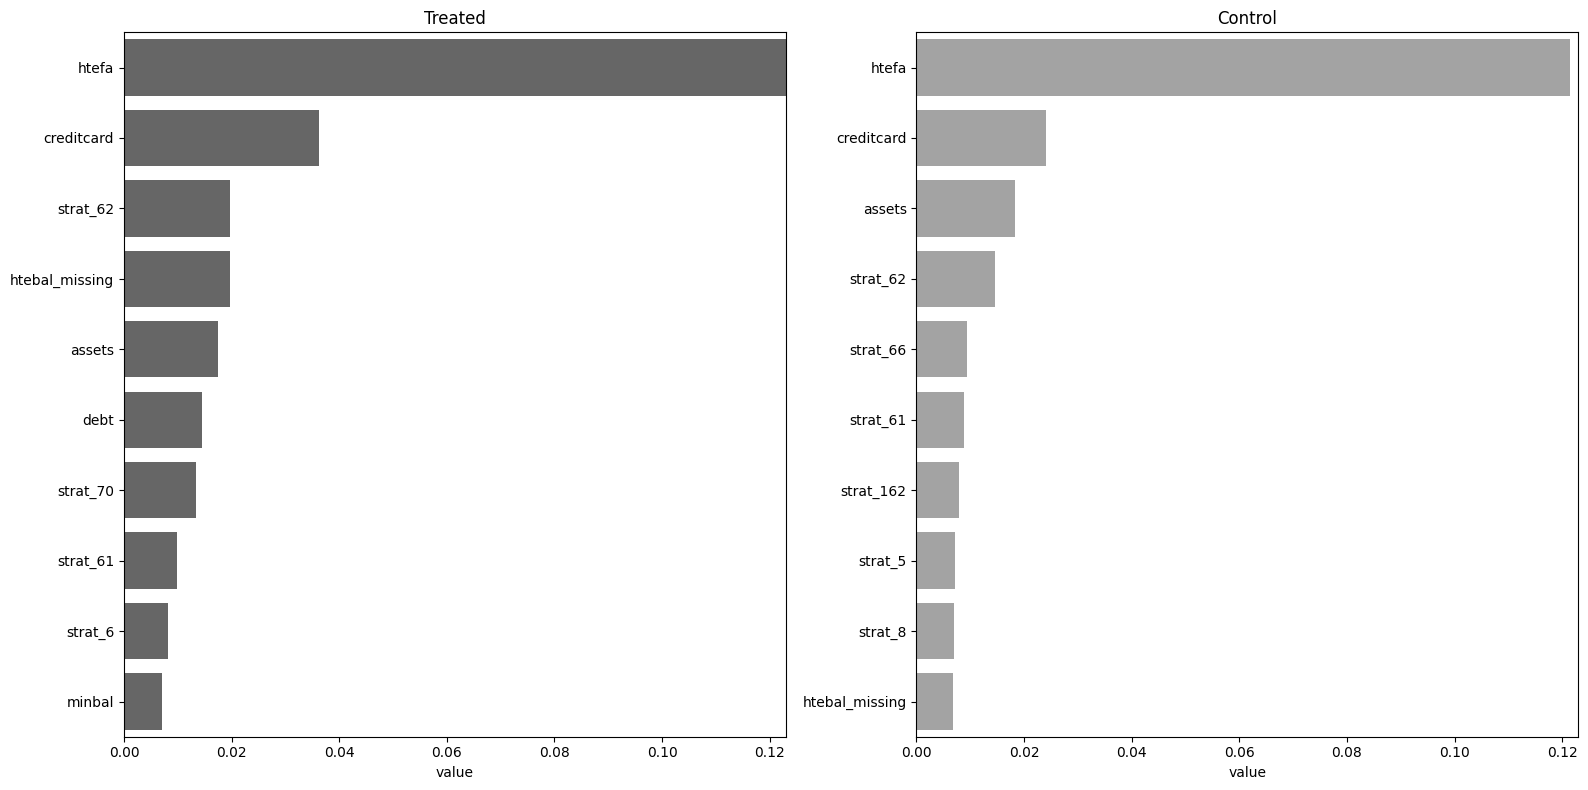

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate Lasso plots for treated vs control
k = 10
plot_treated = df_treated.nlargest(k, 'value').copy()
plot_control = df_control.nlargest(k, 'value').copy()

plt.figure(figsize=(16, 8))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=plot_treated, y='feature', x='value', orient='h', alpha=0.9, color='#555555', ax=ax1)
ax1.set_title('Treated')
ax1.set_ylabel('')

ax2 = plt.subplot(1, 2, 2)
sns.barplot(data=plot_control, y='feature', x='value', orient='h', alpha=0.9, color='#999999', ax=ax2)
ax2.set_title('Control')
ax2.set_ylabel('')

xmax = float(max(
    plot_treated['value'].max() if len(plot_treated) else 0.0,
    plot_control['value'].max() if len(plot_control) else 0.0
))
ax1.set_xlim(0, xmax)
ax2.set_xlim(0, xmax)

plt.tight_layout()
plt.show()


In [9]:
# Generate descriptive table for lasso-filtered covariates (Control vs Treatment)
from pathlib import Path
import numpy as np
import sys
sys.path.insert(0, 'tools')
from descriptive_table import generate_latex_table, generate_csv_table, VARIABLE_INFO

# Load the data with selected features
rv = outcomes[0]
MODEL_CSV = Path(f"output/analysis/{rv}/trainval_data.csv")
df_selected = pd.read_csv(MODEL_CSV)

# Get feature columns (exclude TREATED and outcome)
feature_cols = [c for c in df_selected.columns if c not in ['TREATED', rv]]

# Generate beautified table
latex_content = generate_latex_table(df_selected, feature_cols)
csv_df = generate_csv_table(df_selected, feature_cols)

# Display
print(f"Descriptive Table for {len(feature_cols)} Lasso-Filtered Covariates:")
print("=" * 80)
display(csv_df)

# Save to files
Path("output/tables").mkdir(parents=True, exist_ok=True)
with open("output/tables/descriptive_table_lasso.tex", 'w') as f:
    f.write(latex_content)
csv_df.to_csv("output/tables/descriptive_table_lasso.csv", index=False)

print(f"\n✓ Saved LaTeX to output/tables/descriptive_table_lasso.tex")
print(f"✓ Saved CSV to output/tables/descriptive_table_lasso.csv")

Descriptive Table for 14 Lasso-Filtered Covariates:


,Group,Variable,Abbreviation,Control,Treatment
0,,Overall population,,14434 (50.1%),14385 (49.9%)
1,Randomization Strata,"male, married, low OD limit, other city, unkno...",STRAT5,6 (0.0)%,12 (0.1)%
2,Randomization Strata,"male, married, low OD limit, other city, N/A b...",STRAT6,121 (0.8)%,122 (0.8)%
3,Randomization Strata,"male, married, low OD limit, other city, below...",STRAT8,341 (2.4)%,347 (2.4)%
4,Randomization Strata,"male, unmarried, low OD limit, unknown city, N...",STRAT61,201 (1.4)%,205 (1.4)%
5,Randomization Strata,"male, unmarried, low OD limit, unknown city, z...",STRAT62,625 (4.3)%,624 (4.3)%
6,Randomization Strata,"male, unmarried, low OD limit, other city, zer...",STRAT66,250 (1.7)%,252 (1.8)%
7,Randomization Strata,"male, unmarried, low OD limit, Istanbul, zero ...",STRAT70,84 (0.6)%,84 (0.6)%
8,Randomization Strata,"female, married, low OD limit, unknown city, b...",STRAT162,258 (1.8)%,242 (1.7)%
9,Prior Usage,used overdraft in 6 months pre-treatment,HTEFA,2534 (17.6)%,2465 (17.1)%



✓ Saved LaTeX to output/tables/descriptive_table_lasso.tex
✓ Saved CSV to output/tables/descriptive_table_lasso.csv


### 2.2. Defining parameter grids and base learners

In [12]:
cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 405)
cv_pert_0 = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 0)
cv_pert_1 = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 7)
lasso_grid = {"alpha" : np.logspace(-5,5,500) }
logistic_grid = {"penalty" : ["l1", "l2"], 
                 "C" : np.logspace(-5,5,500)}
rf_grid = {'min_samples_leaf': [50,100,200,300,400,500],
           'max_depth': [3,4,5,6,7,8],
           'bootstrap': [False, True],
           'n_estimators': [100,200,300,400,500]}
xgb_grid = {'max_depth': [5,6,7,8,9,10,11,12],
            'gamma': [0, 0.1, 0.2, 0.3, 0.4],
            'subsample': [0.7, 0.75, 0.8,1],
            'reg_lambda': [100,150,200,250, 300, 350, 400],
            'n_estimators': [200, 300, 400, 500, 600, 700, 800, 900, 1000],
            'min_child_weight': [4,5,6,7,8,9,10],
            'learning_rate': [0.1,0.125,0.15,0.175,0.2,0.225,0.25]}

base_learners = {"lasso" : Lasso(),
                 "logistic" : LogisticRegression(solver = "liblinear", 
                                                 max_iter = 500),
                 "rf" : RandomForestRegressor(),
                 "xgb" : XGBRegressor(objective = "reg:squarederror", n_jobs=1, tree_method="hist")}
param_grids = {"lasso" : lasso_grid,
               "logistic" : logistic_grid,
               "rf" : rf_grid,
               "xgb" : xgb_grid}

## 3. Actual tuning

In [13]:
import os
from methods.cate_estimator_validation import make_estimator_library

# Restrict to model_df (non-holdout) and 'TREATED' column
for rv in outcomes:
    print("=== Getting results for " + rv + " ===")
    cols_needed = [c for c in features] + ["TREATED", rv]
    df_subset = model_df.dropna(subset=[rv]).loc[:, cols_needed].copy()
    from methods.data_processing import separate_vars as _separate

    # Tuning on base (pert_none)
    X, t, y = _separate(df_subset, rv, "TREATED")
    res_base = make_estimator_library(X, t, y, cv, base_learners, param_grids, n_iter=200)
    tuned_base = {est_name: est.get_params() for est_name, est in res_base.items()}

    # Combine and save in per-perturbation format expected by 03
    tuned_map = {"pert_none": tuned_base}
    os.makedirs(f"output/params/{rv}", exist_ok=True)
    joblib.dump(tuned_map, f"output/params/{rv}/{rv}_tuned_params.pkl")

Failed to import duecredit due to No module named 'duecredit'


=== Getting results for fausebal ===
Tuning s_xgb
Tuning s_rf
Tuning t_lasso
Tuning t_logistic
Tuning t_rf
Tuning t_xgb
Tuning x_lasso
Tuning x_logistic
Tuning x_rf
Tuning x_xgb
Tuning r_lassolasso
Tuning r_lassoxgb
Tuning r_lassorf
Tuning r_rflasso
Tuning r_rfrf
Tuning r_rfxgb
Tuning r_xgblasso
Tuning r_xgbrf
Tuning r_xgbxgb
